# TM10007 Assignment template

In [21]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy import stats
from scipy.stats import shapiro, ttest_ind
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    learning_curve,
    GridSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    roc_curve,
    auc
)
from sklearn.feature_selection import (
    RFE,
    SelectKBest,
    SelectFromModel,
    mutual_info_classif,
    chi2
)
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from worclipo.load_data import load_data

In [23]:
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# split feature space in labels and features
features = pd.DataFrame(data)
ground_truth = data['label']
features.pop('label')
ground_truth = ground_truth.map(lambda x: 1 if x == 'liposarcoma' else 0)
print(sum(ground_truth)) # dus de dataset is balanced
#delete features with 1 unique value
constant_columns = [col for col in features.columns if features[col].nunique() == 1]
features = features.drop(columns=constant_columns)
print(f'The number of features (without missing data features): {len(features.columns)}')

#Do first split to get to know the data on the first training set
X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2, random_state=1)
print(f"Aantal samples in training set: {len(X_train)}")
print(f"Aantal samples in test set: {len(X_test)}")

features = np.array(features)
ground_truth = np.array(ground_truth)

The number of samples: 115
The number of columns: 494
58
The number of features (without missing data features): 474
Aantal samples in training set: 92
Aantal samples in test set: 23


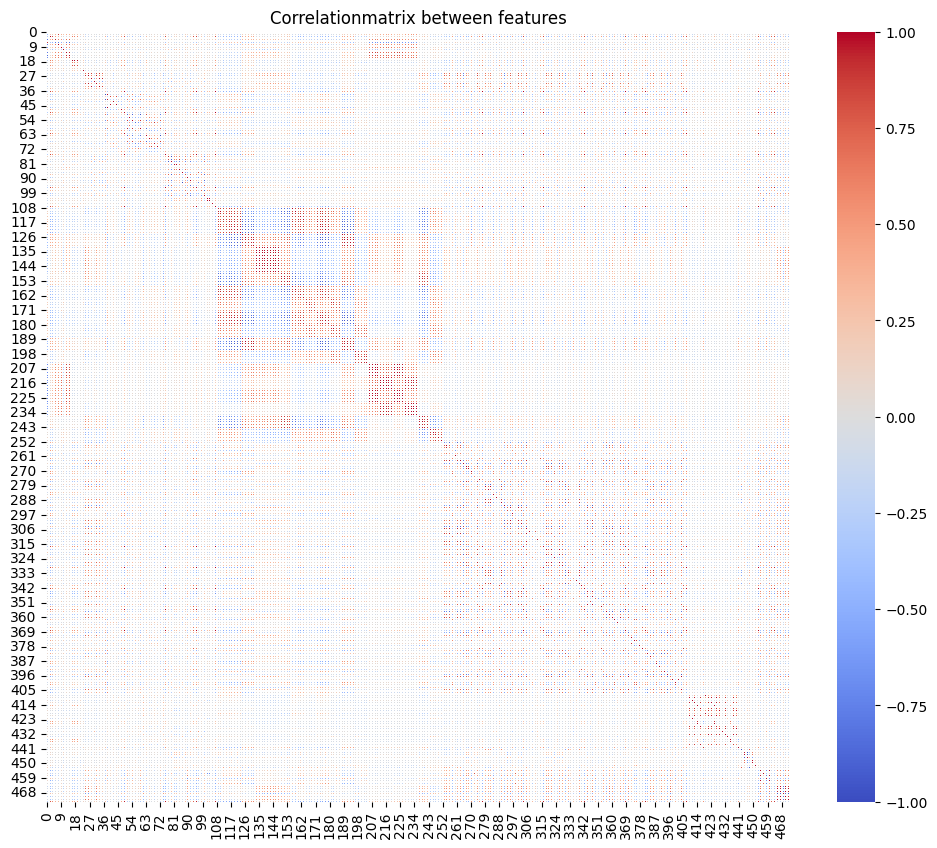

In [ ]:
#plot correlation matrix
corr_matrix = pd.DataFrame(features).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Correlationmatrix between features")
plt.show()
#some functions that are useful from the exercises
def colorplot(clf, ax, x, y, h=100):
    '''
    Overlay the decision areas as colors in an axes.

    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    if len(Z.shape) > 1:
        Z = Z[:, 1]

    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

def plot_roc_curve(y_score, y_truth):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    # y_score = y_score[:, 1]

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    # plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.3, 1.0, 10)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g")
    # axes.legend(loc="best")

    return plt


# Check for each feature if data is normally distributed and plot statistically most optimal features

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Number of features normally distributed in both classes: 64
Number of significantly different features: 34


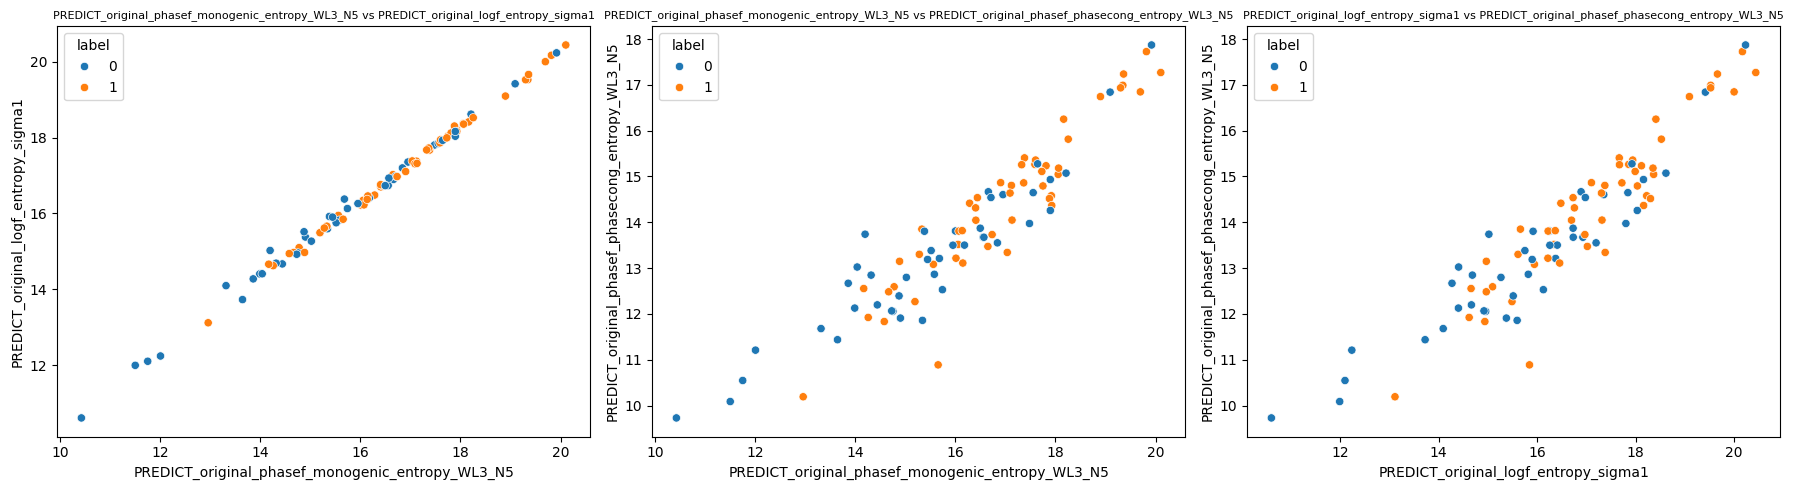

In [26]:
# Shapiro-Wilk test for normality per feature
normal_features = []
for col in X_train.columns:
    class_0 = X_train[col][y_train == 0]
    class_1 = X_train[col][y_train == 1]

    p_0 = shapiro(class_0.values)[1]  # p-value for class 0
    p_1 = shapiro(class_1.values)[1]  # p-value for class 1

    if p_0 > 0.05 and p_1 > 0.05:
        normal_features.append(col)

print(f"Number of features normally distributed in both classes: {len(normal_features)}")

# Independent t-test to find significantly different features
significant_features = []
alpha = 0.05

for col in normal_features:
    class_0 = X_train[col][y_train == 0]
    class_1 = X_train[col][y_train == 1]

    stat, p = ttest_ind(class_0.values, class_1.values, equal_var=False)

    if p < alpha:
        significant_features.append((col, p))

# Sort features by p-value (lowest first)
significant_features.sort(key=lambda x: x[1])

print(f"Number of significantly different features: {len(significant_features)}")

# At least 3 features needed for scatterplots
if len(significant_features) >= 3:
    feature_1, feature_2, feature_3 = [f[0] for f in significant_features[:30:10]]

    # Create scatter plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    sns.scatterplot(x=X_train[feature_1], y=X_train[feature_2], hue=y_train, ax=axes[0])
    axes[0].set_title(f'{feature_1} vs {feature_2}', fontsize=8)

    sns.scatterplot(x=X_train[feature_1], y=X_train[feature_3], hue=y_train, ax=axes[1])
    axes[1].set_title(f'{feature_1} vs {feature_3}', fontsize=8)

    sns.scatterplot(x=X_train[feature_2], y=X_train[feature_3], hue=y_train, ax=axes[2])
    axes[2].set_title(f'{feature_2} vs {feature_3}', fontsize=8)

    plt.tight_layout()
    plt.show()
else:
    print("Not enough significant features to create scatter plots.")


# KNN

## Finding optimal number of components


Testing with PCA variance ratio: 0.1
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run

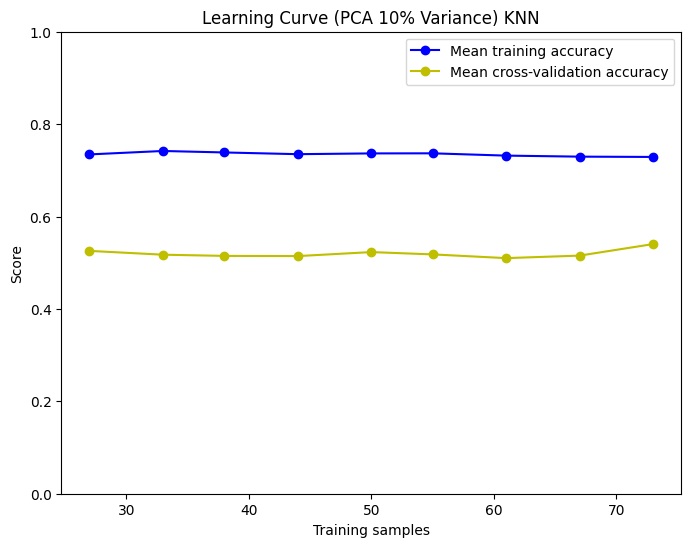


Testing with PCA variance ratio: 0.2
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run

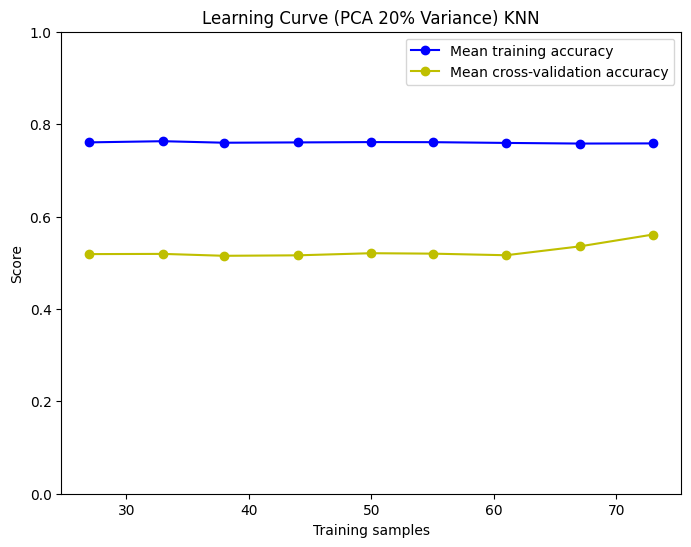


Testing with PCA variance ratio: 0.3
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run

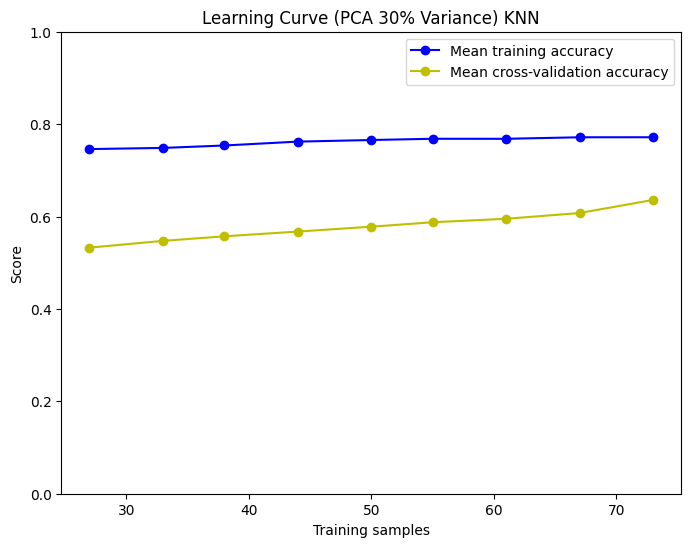


Testing with PCA variance ratio: 0.4
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run

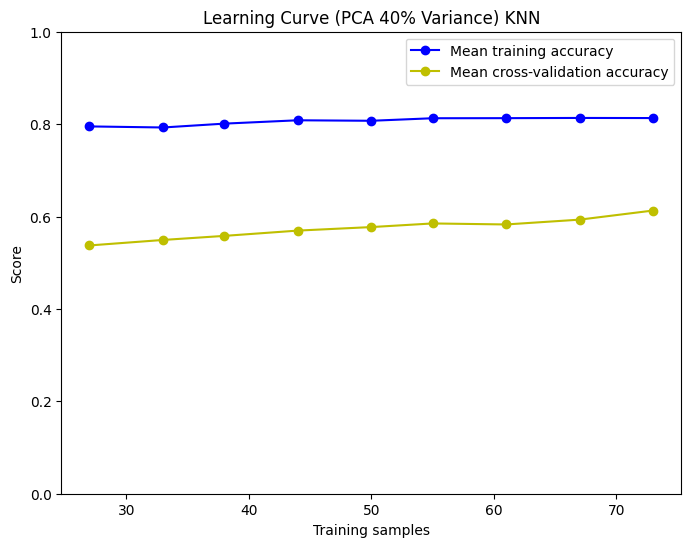


Testing with PCA variance ratio: 0.5
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run

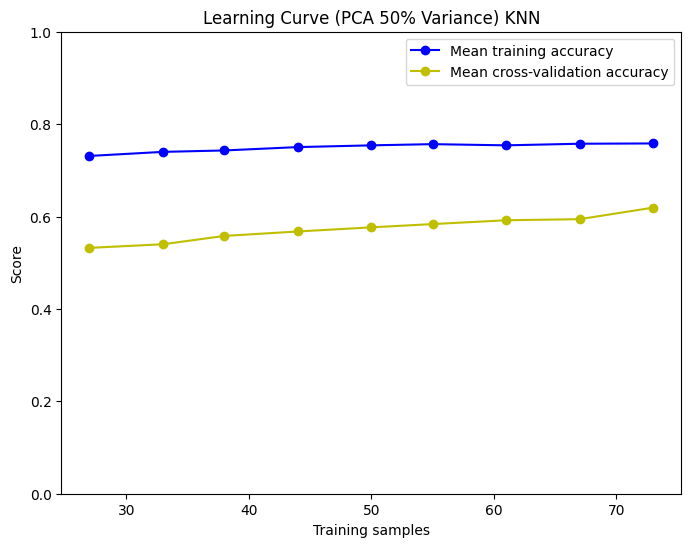


Testing with PCA variance ratio: 0.6
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run

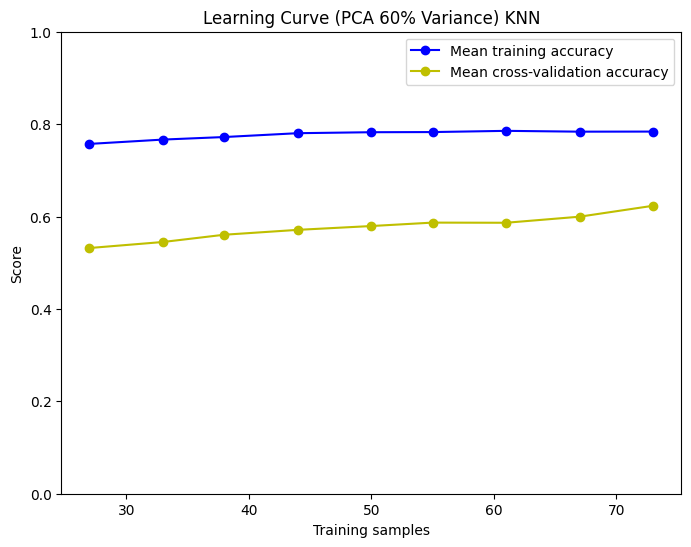


Testing with PCA variance ratio: 0.7
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run

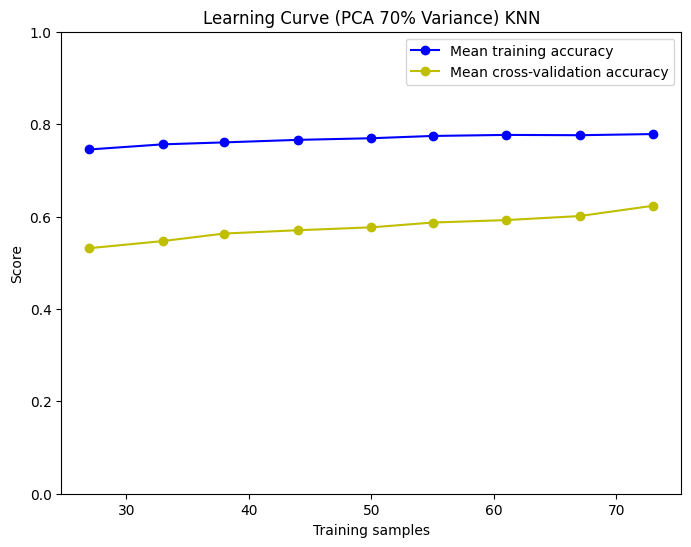


Testing with PCA variance ratio: 0.8
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run

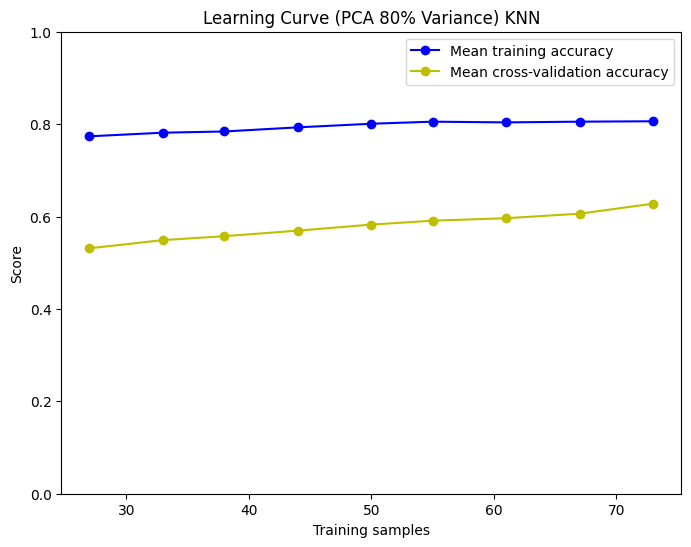


Testing with PCA variance ratio: 0.9
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run

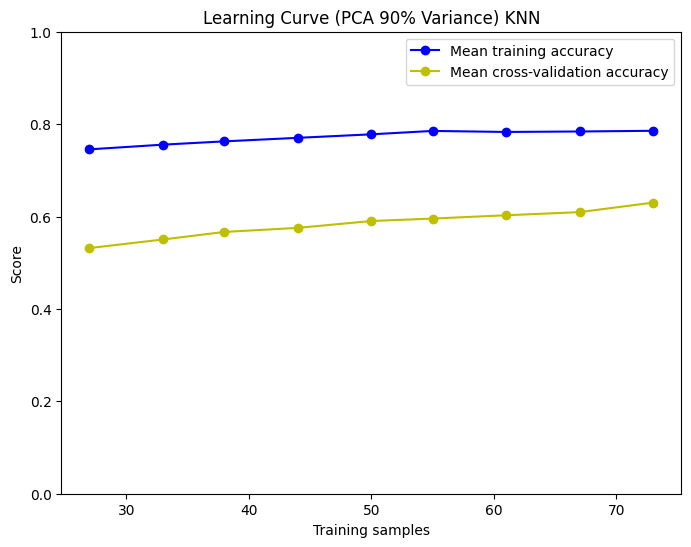


Testing with PCA variance ratio: 0.95
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Ru

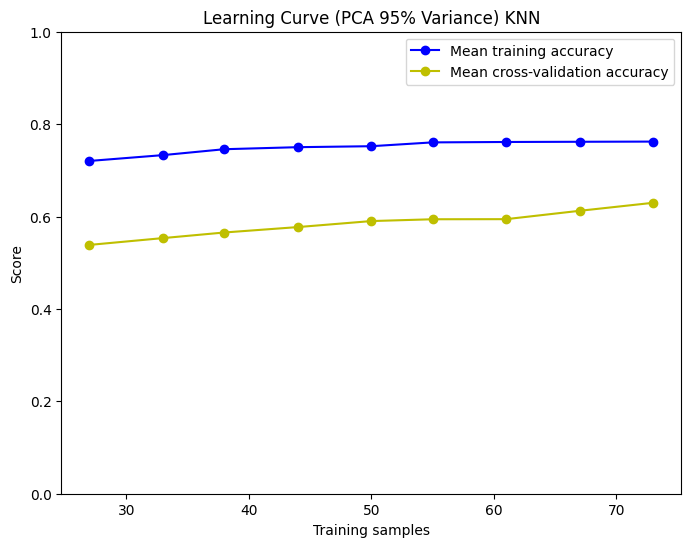

In [ ]:
# Hyperparameter grid
param_grid = {
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__n_neighbors': list(range(5, 30, 5))}

train_sizes_all = np.linspace(.3, 1.0, 10)
components_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

#loop through different percentage of variance described by components
for components in components_range:
    print(f"\nTesting with PCA variance ratio: {components}")

    all_train_scores, all_test_scores = [], []

    fig, axes = plt.subplots(1, 1, figsize=(8, 6))

    for run in range(100):
        print(f"Run {run + 1}/100")

        X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2, random_state=run)

        # Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        #Dimension reduction using PCA
        pca = PCA(n_components=components, random_state = run)

        # Pipeline
        pipeline = make_pipeline(
            pca,
            KNeighborsClassifier()
        )

        #Gridsearch
        clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        clf.fit(X_train_scaled, y_train)

        #Learning curve
        train_sizes, train_scores, test_scores = learning_curve(
            clf.best_estimator_, X_train_scaled, y_train,
            train_sizes=train_sizes_all, cv=5, n_jobs=-1
        )
        all_train_scores.append(np.mean(train_scores, axis=1))
        all_test_scores.append(np.mean(test_scores, axis=1))
    #Plot learning curves
    mean_train_scores = np.mean(all_train_scores, axis=0)
    mean_test_scores = np.mean(all_test_scores, axis=0)

    axes.plot(train_sizes, mean_train_scores, 'o-', color="b", label="Mean training accuracy")
    axes.plot(train_sizes, mean_test_scores, 'o-', color="y", label="Mean cross-validation accuracy")
    axes.set_xlabel("Training samples")
    axes.set_ylabel("Score")
    axes.set_title(f"Learning Curve (PCA {components*100:.0f}% Variance) KNN")
    axes.legend(loc="best")
    axes.set_ylim([0, 1])
    plt.show()

Run 1/100
Beste hyperparameters: {'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'uniform'}
Test accuracy: 0.5217
Sensitivity: 0.6250
Specificity: 0.4667
F1 score: 0.4762
AUC score voor deze run: 0.4792
Run 2/100
Beste hyperparameters: {'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'uniform'}
Test accuracy: 0.4348
Sensitivity: 0.3750
Specificity: 0.4667
F1 score: 0.3158
AUC score voor deze run: 0.4250
Run 3/100
Beste hyperparameters: {'kneighborsclassifier__n_neighbors': 25, 'kneighborsclassifier__weights': 'distance'}
Test accuracy: 0.8261
Sensitivity: 0.7500
Specificity: 0.9091
F1 score: 0.8182
AUC score voor deze run: 0.7879
Run 4/100
Beste hyperparameters: {'kneighborsclassifier__n_neighbors': 20, 'kneighborsclassifier__weights': 'distance'}
Test accuracy: 0.4348
Sensitivity: 0.0833
Specificity: 0.8182
F1 score: 0.1333
AUC score voor deze run: 0.5606
Run 5/100
Beste hyperparameters: {'kneighborsclassifier__n_neighbors': 20, 'kn

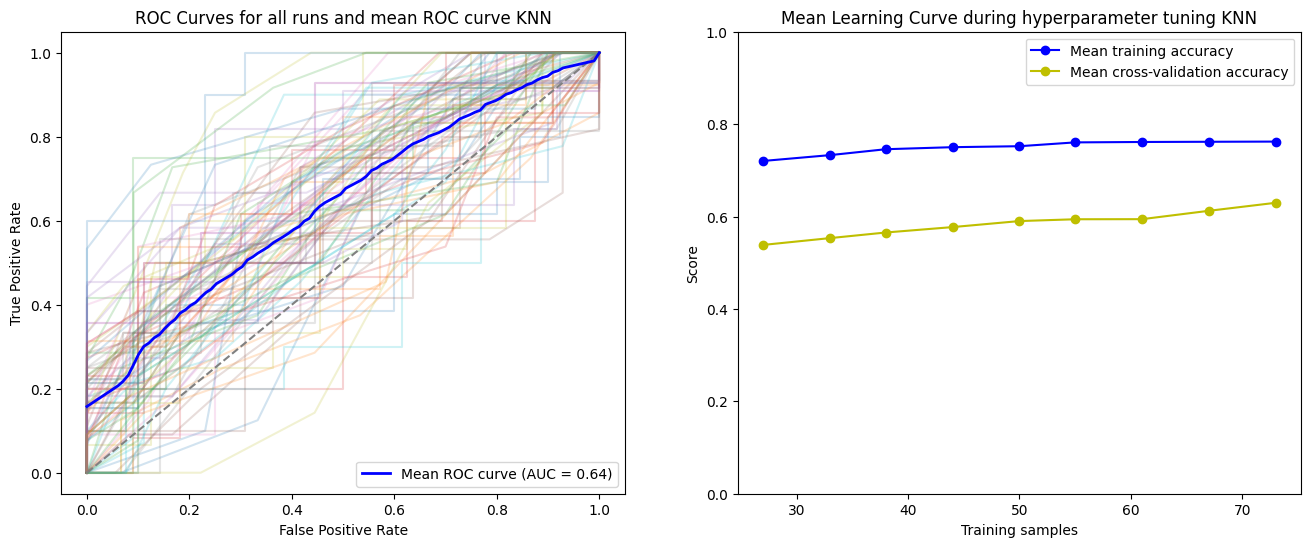

In [31]:
#Initiate testing outcomes
results = []
accuracies = []
sensitivities = []
specificities = []
f1_scores = []
roc_curves = []
auc_scores = []
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)

# Arrays for learning curve data
all_train_scores = []
all_test_scores = []
train_sizes_all = np.linspace(.3, 1.0, 10)
# Create subplots for both ROC and Learning Curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for run in range(100):
    print(f"Run {run + 1}/100")

    # Data split
    X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2, random_state=run)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Dimension reduction using PCA
    pca = PCA(n_components=0.95, random_state=run)

    # Pipeline definiëren
    pipeline = make_pipeline(
        pca,
        KNeighborsClassifier()
    )
    #Parameter grid
    param_grid = {
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__n_neighbors': list(range(5, 30, 5))}
    # Gridsearch
    clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    clf.fit(X_train_scaled, y_train)

    # Test optimal model from gridsearch
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    f1_scores.append(f1)

    # ROC computation
    y_score = clf.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_score = auc(fpr, tpr)
    auc_scores.append(auc_score)
    roc_curves.append((fpr, tpr, auc_score))

    # Results
    results.append({"parameters": clf.best_params_, "accuracy": accuracy, "sensitivity": sensitivity,
                    "specificity": specificity, "f1_score": f1, "auc": auc_score})
    print(f"Beste hyperparameters: {clf.best_params_}")
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 score: {f1:.4f}")
    print(f"AUC score voor deze run: {auc_score:.4f}")

    #ROC curve
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    axes[0].plot(fpr, tpr, alpha=0.2)

    # Learning curve
    train_sizes, train_scores, test_scores = learning_curve(clf.best_estimator_, X_train_scaled, y_train,
                                                            train_sizes=train_sizes_all, cv=5, n_jobs=-1)
    all_train_scores.append(np.mean(train_scores, axis=1))
    all_test_scores.append(np.mean(test_scores, axis=1))

# Calculate mean outcomes
mean_accuracy = np.mean(accuracies)
mean_sensitivity = np.mean(sensitivities)
mean_specificity = np.mean(specificities)
mean_f1_score = np.mean(f1_scores)
mean_auc = np.mean(auc_scores)

std_accuracy = np.std(accuracies)
std_sensitivity = np.std(sensitivities)
std_specificity = np.std(specificities)
std_f1_score = np.std(f1_scores)
std_auc = np.std(auc_scores)

#Mean learningcurve
mean_train_scores = np.mean(all_train_scores, axis=0)
mean_test_scores = np.mean(all_test_scores, axis=0)
# Confidence Intervals (95% CI)
confidence_interval_accuracy = stats.t.interval(0.95, len(accuracies)-1, loc=mean_accuracy, scale=std_accuracy/np.sqrt(len(accuracies)))
confidence_interval_sensitivity = stats.t.interval(0.95, len(sensitivities)-1, loc=mean_sensitivity, scale=std_sensitivity/np.sqrt(len(sensitivities)))
confidence_interval_specificity = stats.t.interval(0.95, len(specificities)-1, loc=mean_specificity, scale=std_specificity/np.sqrt(len(specificities)))
confidence_interval_f1 = stats.t.interval(0.95, len(f1_scores)-1, loc=mean_f1_score, scale=std_f1_score/np.sqrt(len(f1_scores)))
confidence_interval_auc = stats.t.interval(0.95, len(auc_scores)-1, loc=mean_auc, scale=std_auc/np.sqrt(len(auc_scores)))

print(f"\nMean test accuracy over 100 runs: {mean_accuracy:.4f} (SD: {std_accuracy:.4f}, 95% CI: {confidence_interval_accuracy})")
print(f"Mean sensitivity over 100 runs: {mean_sensitivity:.4f} (SD: {std_sensitivity:.4f}, 95% CI: {confidence_interval_sensitivity})")
print(f"Mean specificity over 100 runs: {mean_specificity:.4f} (SD: {std_specificity:.4f}, 95% CI: {confidence_interval_specificity})")
print(f"Mean F1-score over 100 runs: {mean_f1_score:.4f} (SD: {std_f1_score:.4f}, 95% CI: {confidence_interval_f1})")
print(f"Mean AUC over 100 runs: {mean_auc:.4f} (SD: {std_auc:.4f}, 95% CI: {confidence_interval_auc})")

# Sort results
sorted_results = sorted(results, key=lambda x: x["accuracy"], reverse=True)[:10]
print("\nTop 10 Best Results:")
for i, res in enumerate(sorted_results):
    print(f"{i+1}. Hyperparameters: {res['parameters']}, Accuracy: {res['accuracy']:.4f}, Sensitivity: {res['sensitivity']:.4f}, Specificity: {res['specificity']:.4f}, F1: {res['f1_score']:.4f}, AUC: {res['auc']:.4f}")

# ROC-curve plotting
mean_tpr /= 100
# Genereer de gemiddelde ROC-curve
axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[0].plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'Mean ROC curve (AUC = {mean_auc:.2f})')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curves for all runs and mean ROC curve KNN")
axes[0].legend(loc="best")

# Learning curve plotting
axes[1].plot(train_sizes, mean_train_scores, 'o-', color="b", label="Mean training accuracy")
axes[1].plot(train_sizes, mean_test_scores, 'o-', color="y", label="Mean cross-validation accuracy")
axes[1].set_xlabel("Training samples")
axes[1].set_ylabel("Score")
axes[1].set_title("Mean Learning Curve during hyperparameter tuning KNN")
axes[1].set_ylim(0, 1)
axes[1].legend(loc="best")

# Random forest

Run 1/100
Beste hyperparameters: {'max_features': 0.5, 'min_impurity_decrease': 0.005, 'n_estimators': 90}
Test accuracy: 0.6522
Sensitivity: 0.8750
Specificity: 0.5333
F1 score: 0.6364
AUC score voor deze run: 0.8458
Run 2/100
Beste hyperparameters: {'max_features': 0.5, 'min_impurity_decrease': 0.1, 'n_estimators': 75}
Test accuracy: 0.6957
Sensitivity: 0.7500
Specificity: 0.6667
F1 score: 0.6316
AUC score voor deze run: 0.7333
Run 3/100
Beste hyperparameters: {'max_features': 0.5, 'min_impurity_decrease': 0.2, 'n_estimators': 60}
Test accuracy: 0.7826
Sensitivity: 0.5833
Specificity: 1.0000
F1 score: 0.7368
AUC score voor deze run: 0.8864
Run 4/100
Beste hyperparameters: {'max_features': 0.5, 'min_impurity_decrease': 0.1, 'n_estimators': 60}
Test accuracy: 0.7391
Sensitivity: 0.5000
Specificity: 1.0000
F1 score: 0.6667
AUC score voor deze run: 0.7652
Run 5/100
Beste hyperparameters: {'max_features': 0.5, 'min_impurity_decrease': 0.1, 'n_estimators': 90}
Test accuracy: 0.7826
Sensiti

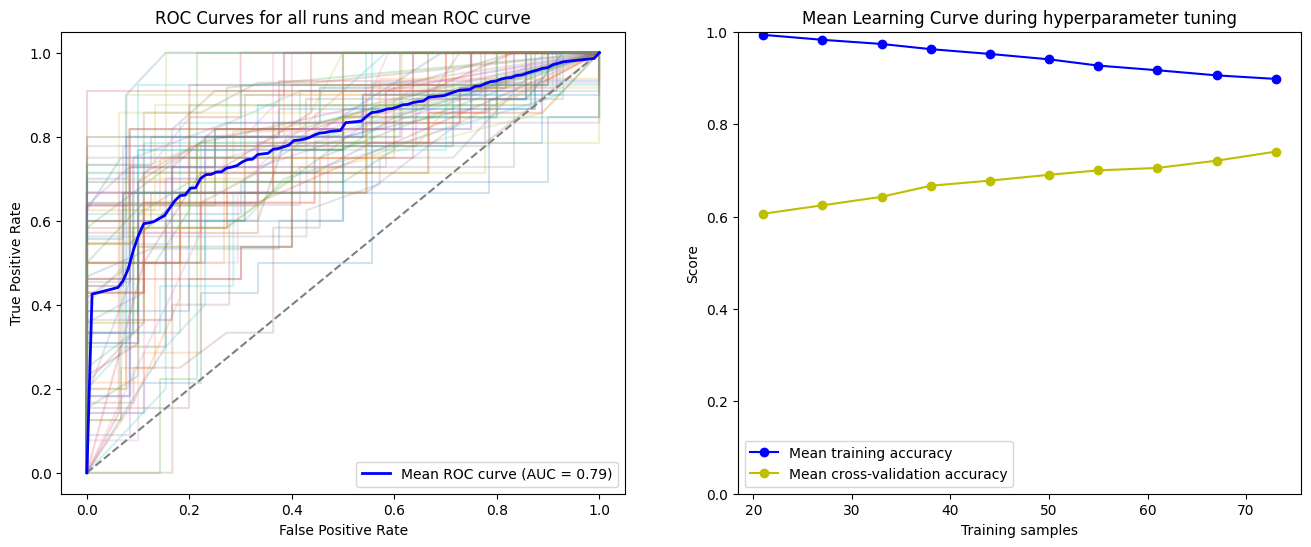

In [ ]:
# Hyperparameter grid
param_grid = {
        'n_estimators': [60, 75, 90],
        'min_impurity_decrease': [0.005, 0.1, 0.2],
        'max_features': [0.5]
    }

# Initiate testing results
results = []
accuracies = []
sensitivities = []
specificities = []
f1_scores = []
roc_curves = []
auc_scores = []
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)

all_train_scores = []
all_test_scores = []
train_sizes_all = np.linspace(.3, 1.0, 10)

# Create subplots for both ROC and Learning Curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Amount of random splits
split = 100

for run in range(split):
    print(f"Run {run + 1}/{split}")

    # Data split
    X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2, random_state=run)

    # Random Forest model
    forest = RandomForestClassifier(random_state=run)

    # GridSearch
    clf = GridSearchCV(forest, param_grid, cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)

    # Test optimal model from grid search
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    f1_scores.append(f1)

    # ROC
    y_score = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_score = auc(fpr, tpr)
    auc_scores.append(auc_score)
    roc_curves.append((fpr, tpr, auc_score))

    # Resultats
    results.append({"parameters": clf.best_params_, "accuracy": accuracy, "sensitivity": sensitivity,
                    "specificity": specificity, "f1_score": f1, "auc": auc_score})
    print(f"Beste hyperparameters: {clf.best_params_}")
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 score: {f1:.4f}")
    print(f"AUC score voor deze run: {auc_score:.4f}")

    # ROC plot
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    axes[0].plot(fpr, tpr, alpha=0.2)

    # Learning curve
    train_sizes, train_scores, test_scores = learning_curve(clf.best_estimator_, X_train, y_train,
                                                            train_sizes=train_sizes_all, cv=5, n_jobs=-1)
    all_train_scores.append(np.mean(train_scores, axis=1))
    all_test_scores.append(np.mean(test_scores, axis=1))

# Mean and standard deviation results
mean_accuracy = np.mean(accuracies)
mean_sensitivity = np.mean(sensitivities)
mean_specificity = np.mean(specificities)
mean_f1_score = np.mean(f1_scores)
mean_auc = np.mean(auc_scores)

std_accuracy = np.std(accuracies)
std_sensitivity = np.std(sensitivities)
std_specificity = np.std(specificities)
std_f1_score = np.std(f1_scores)
std_auc = np.std(auc_scores)

mean_train_scores = np.mean(all_train_scores, axis=0)
mean_test_scores = np.mean(all_test_scores, axis=0)
# Confidence Intervals (95% CI)
confidence_interval_accuracy = stats.t.interval(0.95, len(accuracies)-1, loc=mean_accuracy, scale=std_accuracy/np.sqrt(len(accuracies)))
confidence_interval_sensitivity = stats.t.interval(0.95, len(sensitivities)-1, loc=mean_sensitivity, scale=std_sensitivity/np.sqrt(len(sensitivities)))
confidence_interval_specificity = stats.t.interval(0.95, len(specificities)-1, loc=mean_specificity, scale=std_specificity/np.sqrt(len(specificities)))
confidence_interval_f1 = stats.t.interval(0.95, len(f1_scores)-1, loc=mean_f1_score, scale=std_f1_score/np.sqrt(len(f1_scores)))
confidence_interval_auc = stats.t.interval(0.95, len(auc_scores)-1, loc=mean_auc, scale=std_auc/np.sqrt(len(auc_scores)))

print(f"\nMean test accuracy over 100 runs: {mean_accuracy:.4f} (SD: {std_accuracy:.4f}, 95% CI: {confidence_interval_accuracy})")
print(f"Mean sensitivity over 100 runs: {mean_sensitivity:.4f} (SD: {std_sensitivity:.4f}, 95% CI: {confidence_interval_sensitivity})")
print(f"Mean specificity over 100 runs: {mean_specificity:.4f} (SD: {std_specificity:.4f}, 95% CI: {confidence_interval_specificity})")
print(f"Mean F1-score over 100 runs: {mean_f1_score:.4f} (SD: {std_f1_score:.4f}, 95% CI: {confidence_interval_f1})")
print(f"Mean AUC over 100 runs: {mean_auc:.4f} (SD: {std_auc:.4f}, 95% CI: {confidence_interval_auc})")

# Sort results
sorted_results = sorted(results, key=lambda x: x["accuracy"], reverse=True)[:10]
print("\nTop 10 Best Results:")
for i, res in enumerate(sorted_results):
    print(f"{i+1}. Hyperparameters: {res['parameters']}, Accuracy: {res['accuracy']:.4f}, Sensitivity: {res['sensitivity']:.4f}, Specificity: {res['specificity']:.4f}, F1: {res['f1_score']:.4f}, AUC: {res['auc']:.4f}")

# ROC-curve plotting
mean_tpr /= 100
mean_tpr [0] = 0

axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[0].plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'Mean ROC curve (AUC = {mean_auc:.2f})')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curves for all runs and mean ROC curve")
axes[0].legend(loc="best")

# Learning curve plotting
axes[1].plot(train_sizes, mean_train_scores, 'o-', color="b", label="Mean training accuracy")
axes[1].plot(train_sizes, mean_test_scores, 'o-', color="y", label="Mean cross-validation accuracy")
axes[1].set_xlabel("Training samples")
axes[1].set_ylabel("Score")
axes[1].set_title("Mean Learning Curve during hyperparameter tuning")
axes[1].set_ylim(0, 1)
axes[1].legend(loc="best")

#SVM


##SVM - PCA component selection with learning curves from the training data


Cross-validation with PCA variance ratio in trainingset: 0.1
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Ru

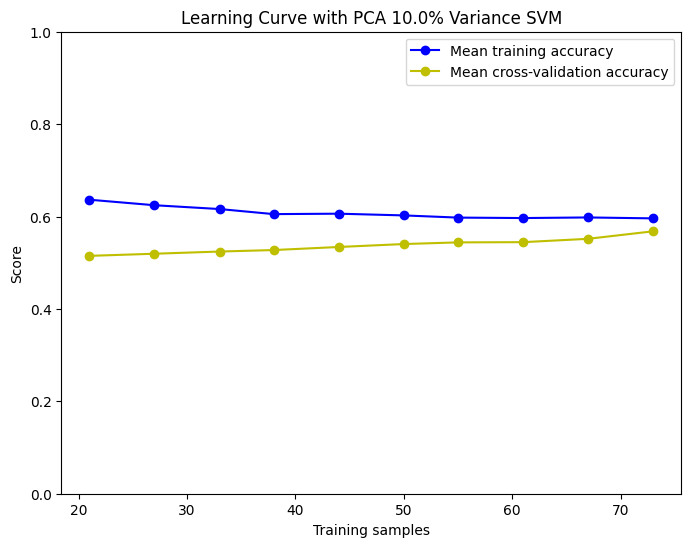

Cross-validation with PCA variance ratio in trainingset: 0.2
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Ru

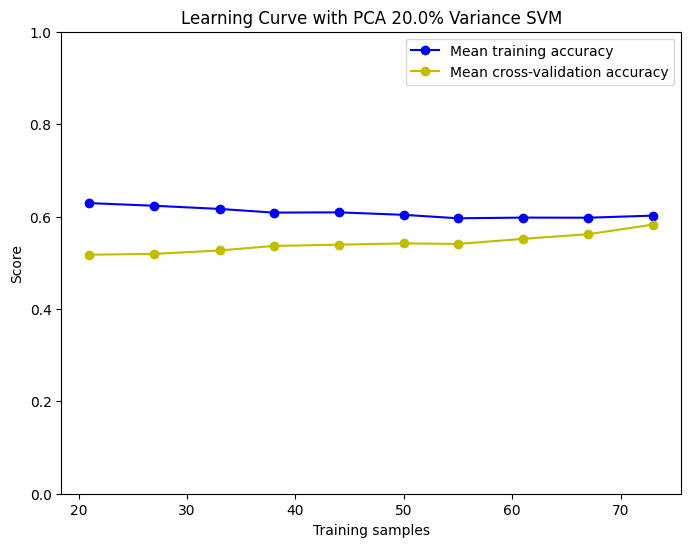

Cross-validation with PCA variance ratio in trainingset: 0.3
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Ru

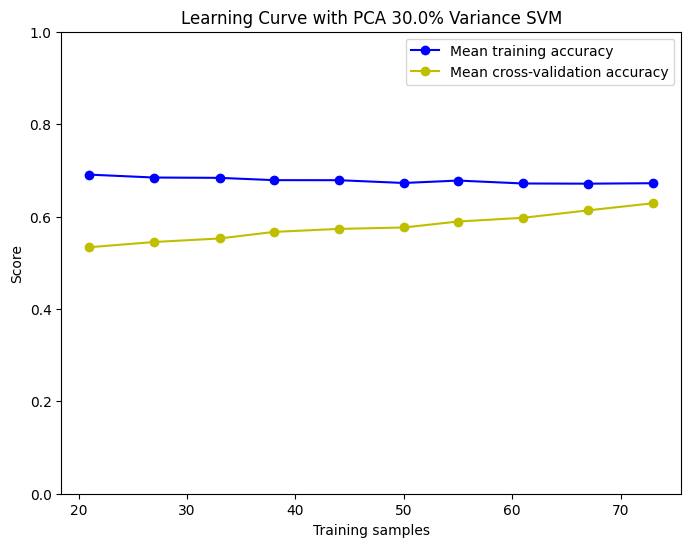

Cross-validation with PCA variance ratio in trainingset: 0.4
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Ru

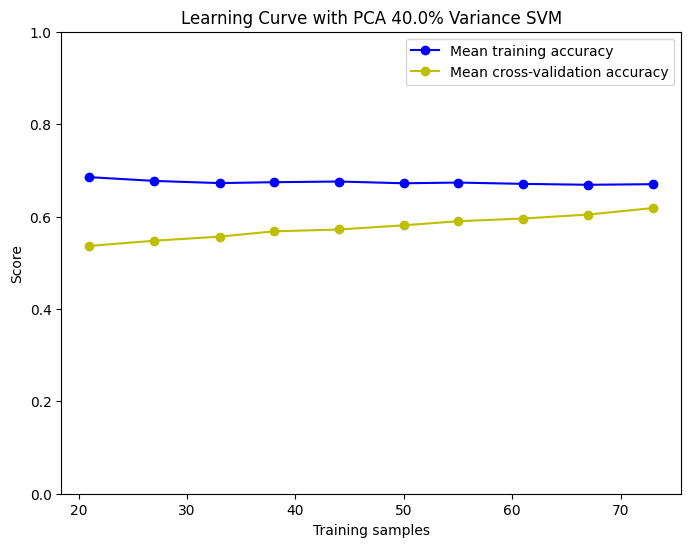

Cross-validation with PCA variance ratio in trainingset: 0.5
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Ru

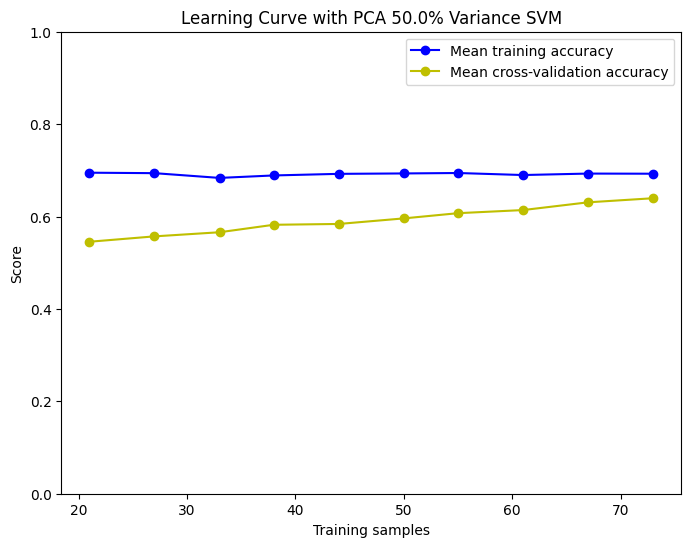

Cross-validation with PCA variance ratio in trainingset: 0.6
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Ru

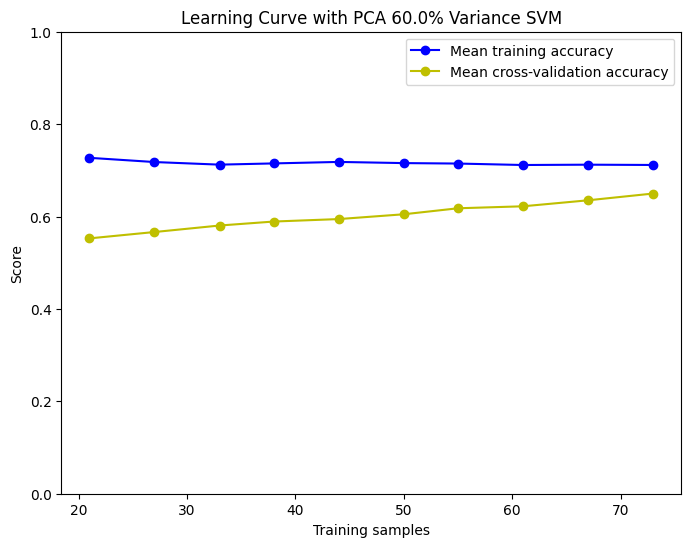

Cross-validation with PCA variance ratio in trainingset: 0.7
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Ru

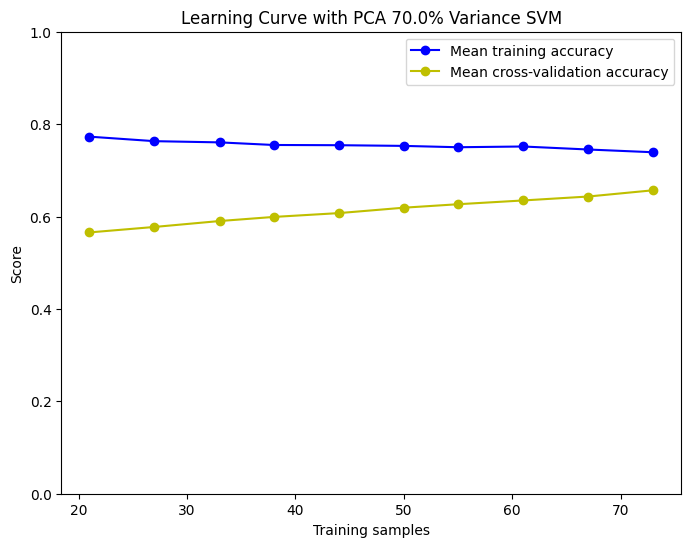

Cross-validation with PCA variance ratio in trainingset: 0.8
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Ru

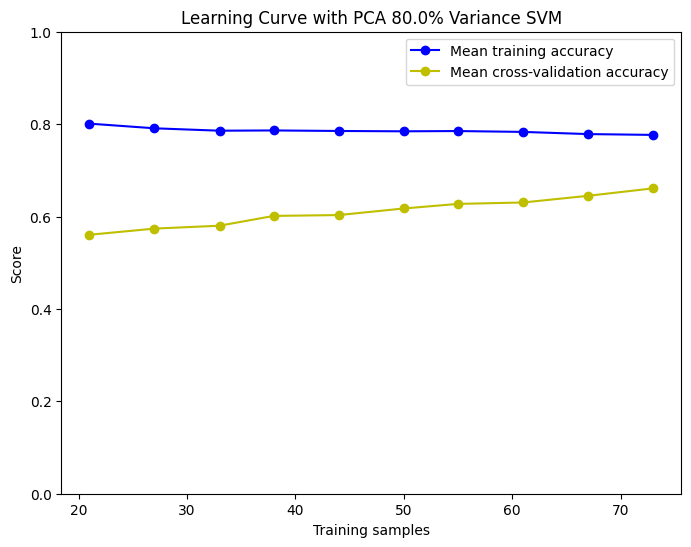

Cross-validation with PCA variance ratio in trainingset: 0.9
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Ru

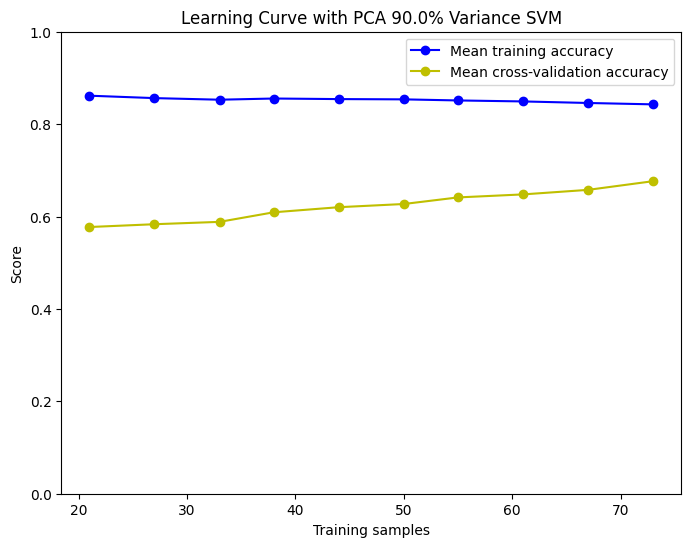

Cross-validation with PCA variance ratio in trainingset: 0.95
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
R

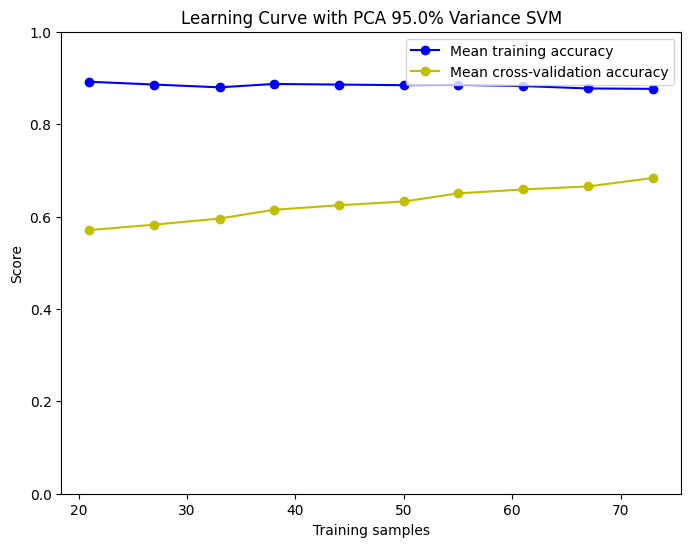

In [ ]:
# Hyperparameter grid
param_grid = [
    {'svc__C': [0.001, 0.01, 0.1, 0.5], 'svc__kernel': ['linear']},
    {'svc__C': [0.001, 0.01, 0.1, 0.5], 'svc__kernel': ['rbf'], 'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
    {'svc__C': [0.001, 0.01, 0.1, 0.5], 'svc__kernel': ['poly'], 'svc__degree': [2, 3, 4, 5]}
]
train_sizes_all = np.linspace(.3, 1.0, 10)

# Loop for different percentages of variation described by PCA
components_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

for components in components_range:
    print(f"Cross-validation with PCA variance ratio in trainingset: {components}")


    # Initiate learning curve data
    all_train_scores = []
    all_test_scores = []
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))

    # 100 Random Splits
    for run in range(100):
        print(f"Run {run + 1}/100")

        # Data split
        X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2, random_state=run)

        # Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # PCA
        pca = PCA(n_components=components, random_state = run)  # Aantal componenten op basis van de variantie

        # SVM
        svm = SVC(probability=True, random_state = run)  # Probability=True nodig voor ROC

        # Pipeline
        pipeline = make_pipeline(pca, svm)

        # GridSearch
        clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
        clf.fit(X_train_scaled, y_train)

        # Learning curve
        train_sizes, train_scores, test_scores = learning_curve(clf.best_estimator_, X_train_scaled, y_train,
                                                                train_sizes=train_sizes_all, cv=5, n_jobs=-1)
        all_train_scores.append(np.mean(train_scores, axis=1))
        all_test_scores.append(np.mean(test_scores, axis=1))

    # Mean learning curve
    mean_train_scores = np.mean(all_train_scores, axis=0)
    mean_test_scores = np.mean(all_test_scores, axis=0)
    axes.plot(train_sizes, mean_train_scores, 'o-', color="b", label="Mean training accuracy")
    axes.plot(train_sizes, mean_test_scores, 'o-', color="y", label="Mean cross-validation accuracy")
    axes.set_xlabel("Training samples")
    axes.set_ylabel("Score")
    axes.set_title(f"Learning Curve with PCA {components*100}% Variance SVM")
    axes.legend(loc="best")
    axes.set_ylim([0, 1])
    plt.show()


## SVM - total pipeline including testing on testset

Run 1/100
Beste hyperparameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Test accuracy: 0.5652
Sensitivity: 0.5000
Specificity: 0.6000
F1 score: 0.4444
AUC score voor deze run: 0.5833
Run 2/100
Beste hyperparameters: {'svc__C': 0.01, 'svc__kernel': 'linear'}
Test accuracy: 0.5217
Sensitivity: 0.8750
Specificity: 0.3333
F1 score: 0.5600
AUC score voor deze run: 0.4750
Run 3/100
Beste hyperparameters: {'svc__C': 0.01, 'svc__kernel': 'linear'}
Test accuracy: 0.6957
Sensitivity: 0.6667
Specificity: 0.7273
F1 score: 0.6957
AUC score voor deze run: 0.8333
Run 4/100
Beste hyperparameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Test accuracy: 0.5217
Sensitivity: 0.2500
Specificity: 0.8182
F1 score: 0.3529
AUC score voor deze run: 0.6742
Run 5/100
Beste hyperparameters: {'svc__C': 0.5, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Test accuracy: 0.6087
Sensitivity: 0.8889
Specificity: 0.4286
F1 score: 0.6400
AUC score voor deze run: 0.1905
Run 6/100
Beste hyperparameters: {'svc__C': 0.01, 'svc_

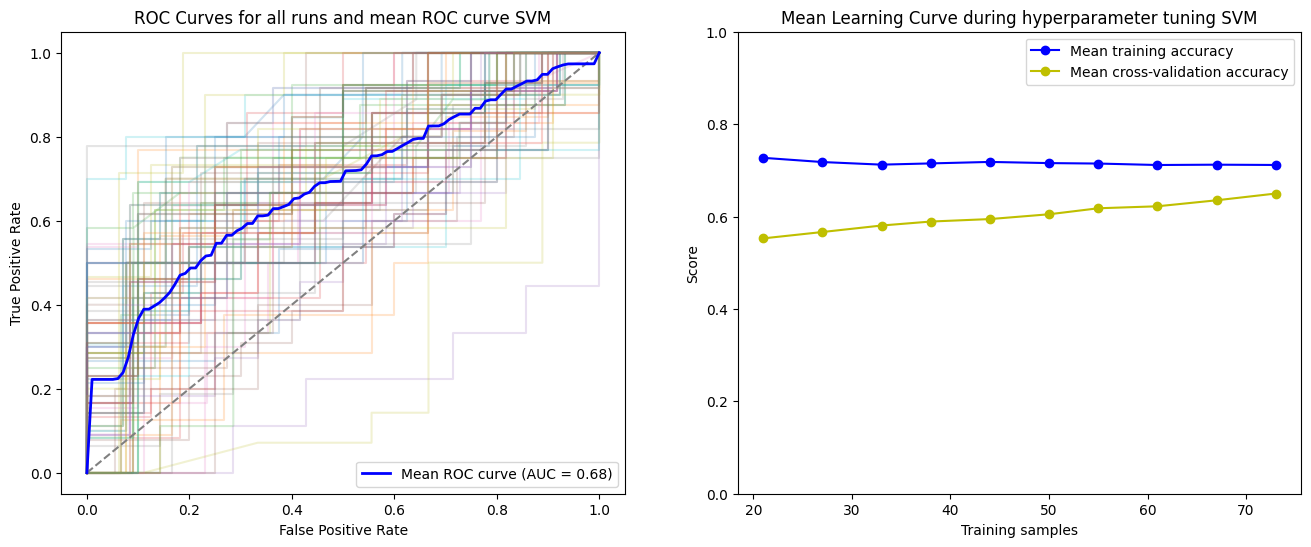

In [ ]:
# Hyperparameter grid
param_grid = [
    {'svc__C': [0.001, 0.01, 0.1, 0.5], 'svc__kernel': ['linear']},
    {'svc__C': [0.001, 0.01, 0.1, 0.5], 'svc__kernel': ['rbf'], 'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
    {'svc__C': [0.001, 0.01, 0.1, 0.5], 'svc__kernel': ['poly'], 'svc__degree': [2, 3, 4, 5]}
]
# Initiate testing results
results = []
accuracies = []
sensitivities = []
specificities = []
f1_scores = []
roc_curves = []
auc_scores = []
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)

# Arrays for learning curve data
all_train_scores = []
all_test_scores = []
train_sizes_all = np.linspace(.3, 1.0, 10)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 100 Random Splits
for run in range(100):
    print(f"Run {run + 1}/100")

    # Data split
    X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2, random_state=run)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # PCA
    pca = PCA(n_components = 0.6, random_state = run)

    # SVM
    svm = SVC(probability=True)  # Probability=True nodig voor ROC

    # Pipeline
    pipeline = make_pipeline(pca, svm)

    # GridSearch
    clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    clf.fit(X_train_scaled, y_train)

    # Test most optimal model from gridsearch
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    f1_scores.append(f1)

    # ROC
    y_score = clf.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_score = auc(fpr, tpr)
    auc_scores.append(auc_score)
    roc_curves.append((fpr, tpr, auc_score))

    # Results
    results.append({"parameters": clf.best_params_, "accuracy": accuracy, "sensitivity": sensitivity,
                    "specificity": specificity, "f1_score": f1, "auc": auc_score})
    print(f"Beste hyperparameters: {clf.best_params_}")
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 score: {f1:.4f}")
    print(f"AUC score voor deze run: {auc_score:.4f}")

    # ROC
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    axes[0].plot(fpr, tpr, alpha=0.2)

    # Learning curve
    train_sizes, train_scores, test_scores = learning_curve(clf.best_estimator_, X_train_scaled, y_train,
                                                            train_sizes=train_sizes_all, cv=5, n_jobs=-1)
    all_train_scores.append(np.mean(train_scores, axis=1))
    all_test_scores.append(np.mean(test_scores, axis=1))

# mean and standarddeviation of results
mean_accuracy = np.mean(accuracies)
mean_sensitivity = np.mean(sensitivities)
mean_specificity = np.mean(specificities)
mean_f1_score = np.mean(f1_scores)
mean_auc = np.mean(auc_scores)

std_accuracy = np.std(accuracies)
std_sensitivity = np.std(sensitivities)
std_specificity = np.std(specificities)
std_f1_score = np.std(f1_scores)
std_auc = np.std(auc_scores)


mean_train_scores = np.mean(all_train_scores, axis=0)
mean_test_scores = np.mean(all_test_scores, axis=0)
# Confidence Intervals (95% CI)
confidence_interval_accuracy = stats.t.interval(0.95, len(accuracies)-1, loc=mean_accuracy, scale=std_accuracy/np.sqrt(len(accuracies)))
confidence_interval_sensitivity = stats.t.interval(0.95, len(sensitivities)-1, loc=mean_sensitivity, scale=std_sensitivity/np.sqrt(len(sensitivities)))
confidence_interval_specificity = stats.t.interval(0.95, len(specificities)-1, loc=mean_specificity, scale=std_specificity/np.sqrt(len(specificities)))
confidence_interval_f1 = stats.t.interval(0.95, len(f1_scores)-1, loc=mean_f1_score, scale=std_f1_score/np.sqrt(len(f1_scores)))
confidence_interval_auc = stats.t.interval(0.95, len(auc_scores)-1, loc=mean_auc, scale=std_auc/np.sqrt(len(auc_scores)))

print(f"\nMean test accuracy over 100 runs: {mean_accuracy:.4f} (SD: {std_accuracy:.4f}, 95% CI: {confidence_interval_accuracy})")
print(f"Mean sensitivity over 100 runs: {mean_sensitivity:.4f} (SD: {std_sensitivity:.4f}, 95% CI: {confidence_interval_sensitivity})")
print(f"Mean specificity over 100 runs: {mean_specificity:.4f} (SD: {std_specificity:.4f}, 95% CI: {confidence_interval_specificity})")
print(f"Mean F1-score over 100 runs: {mean_f1_score:.4f} (SD: {std_f1_score:.4f}, 95% CI: {confidence_interval_f1})")
print(f"Mean AUC over 100 runs: {mean_auc:.4f} (SD: {std_auc:.4f}, 95% CI: {confidence_interval_auc})")

# Sort results
sorted_results = sorted(results, key=lambda x: x["accuracy"], reverse=True)[:10]
print("\nTop 10 Best Results:")
for i, res in enumerate(sorted_results):
    print(f"{i+1}. Hyperparameters: {res['parameters']}, Accuracy: {res['accuracy']:.4f}, Sensitivity: {res['sensitivity']:.4f}, Specificity: {res['specificity']:.4f}, F1: {res['f1_score']:.4f}, AUC: {res['auc']:.4f}")

# ROC-curve plotting
mean_tpr /= 100
mean_tpr[0]=0

axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[0].plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'Mean ROC curve (AUC = {mean_auc:.2f})')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curves for all runs and mean ROC curve SVM")
axes[0].legend(loc="best")

# Learning curve plotting
axes[1].plot(train_sizes, mean_train_scores, 'o-', color="b", label="Mean training accuracy")
axes[1].plot(train_sizes, mean_test_scores, 'o-', color="y", label="Mean cross-validation accuracy")
axes[1].set_xlabel("Training samples")
axes[1].set_ylabel("Score")
axes[1].set_title("Mean Learning Curve during hyperparameter tuning SVM")
axes[1].set_ylim(0, 1)
axes[1].legend(loc="best")

# LDA


##LDA - PCA component selection with learning curves from the training data

Testing with PCA variance ratio: 0.1
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run 

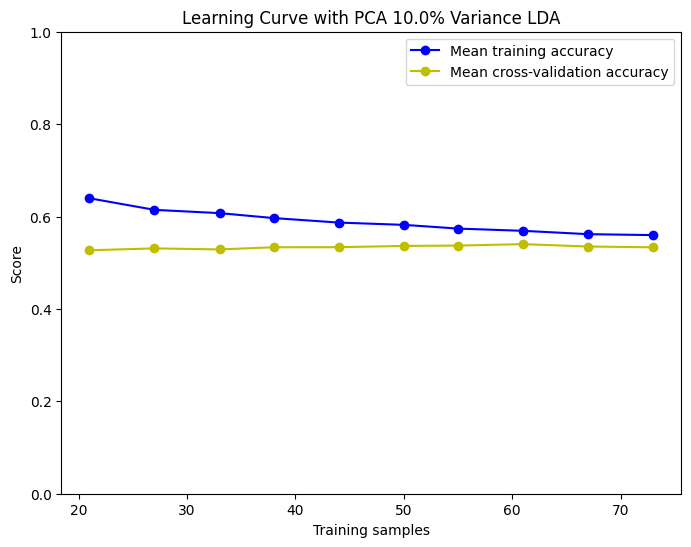

Testing with PCA variance ratio: 0.2
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run 

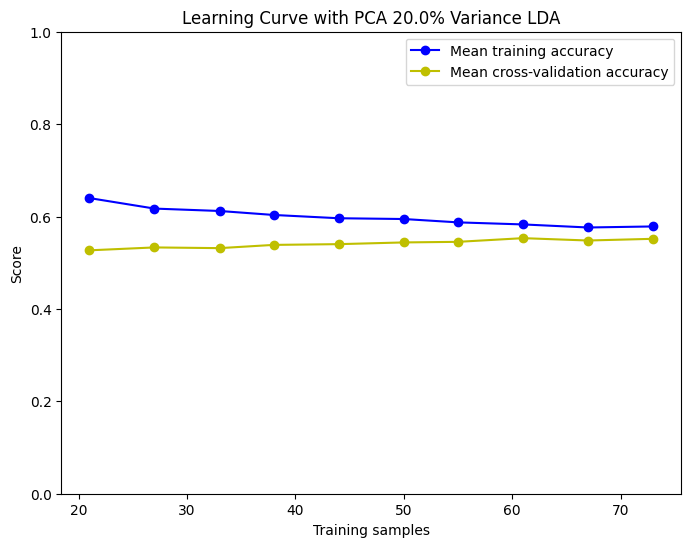

Testing with PCA variance ratio: 0.3
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run 

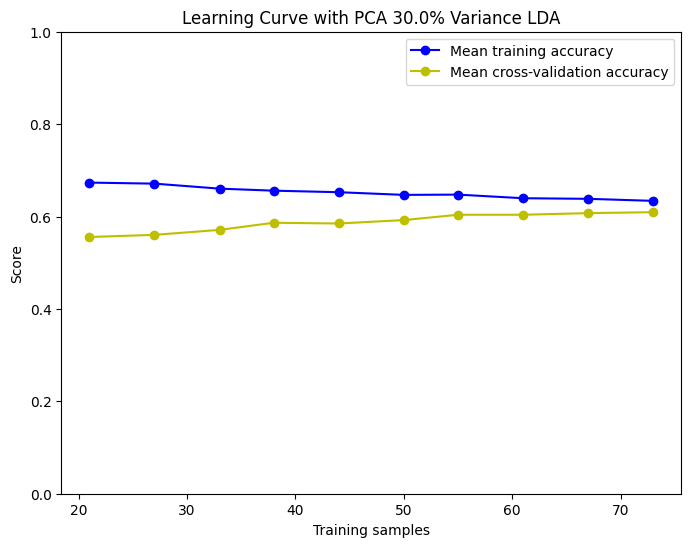

Testing with PCA variance ratio: 0.4
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run 

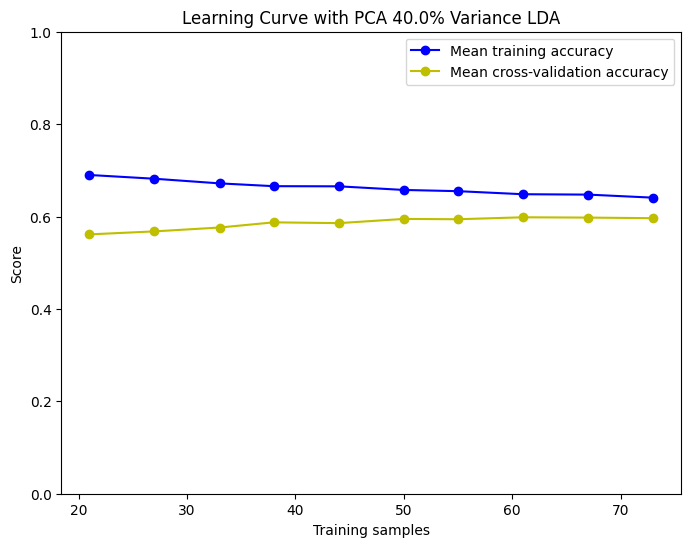

Testing with PCA variance ratio: 0.5
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run 

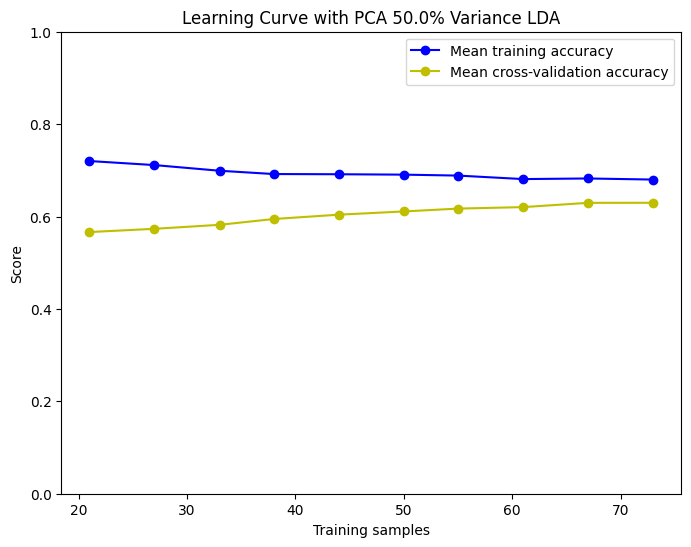

Testing with PCA variance ratio: 0.6
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run 

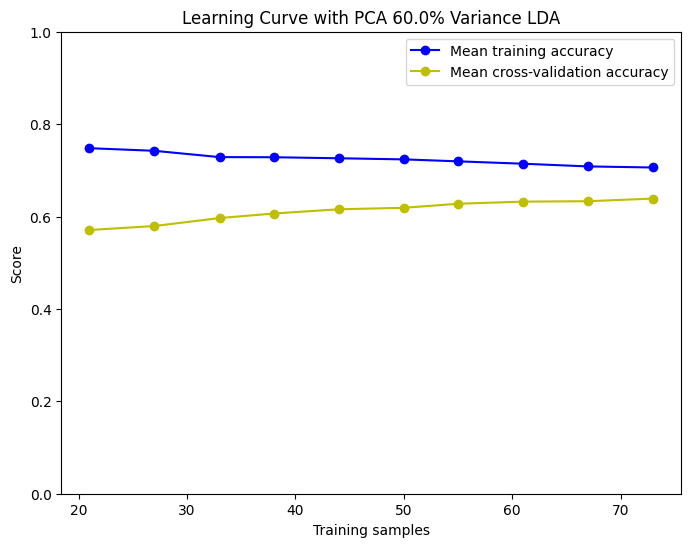

Testing with PCA variance ratio: 0.7
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run 

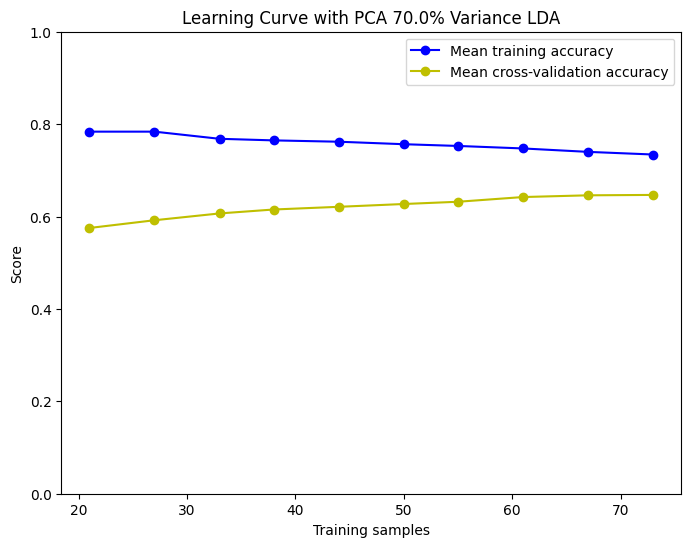

Testing with PCA variance ratio: 0.8
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run 

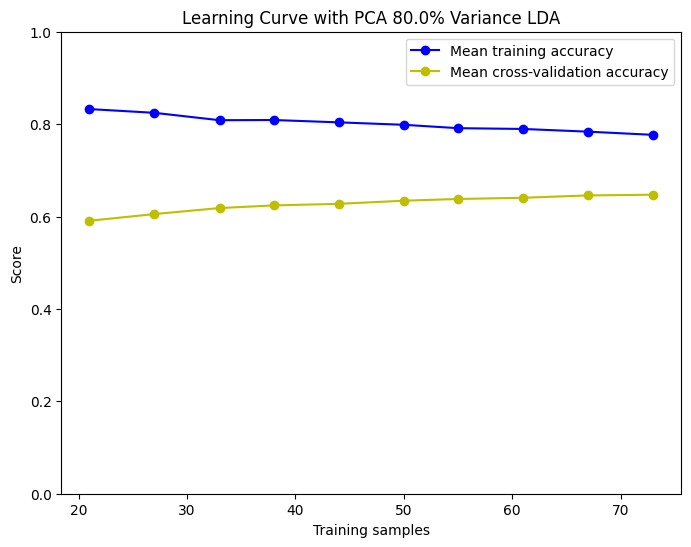

Testing with PCA variance ratio: 0.9
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run 

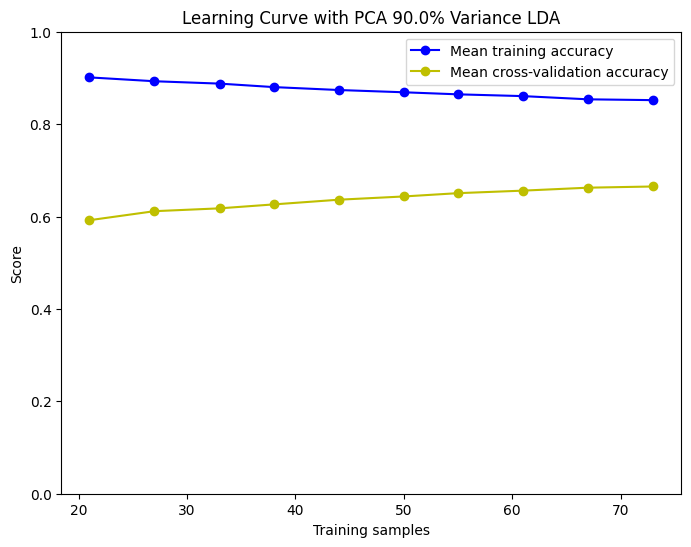

Testing with PCA variance ratio: 0.95
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run

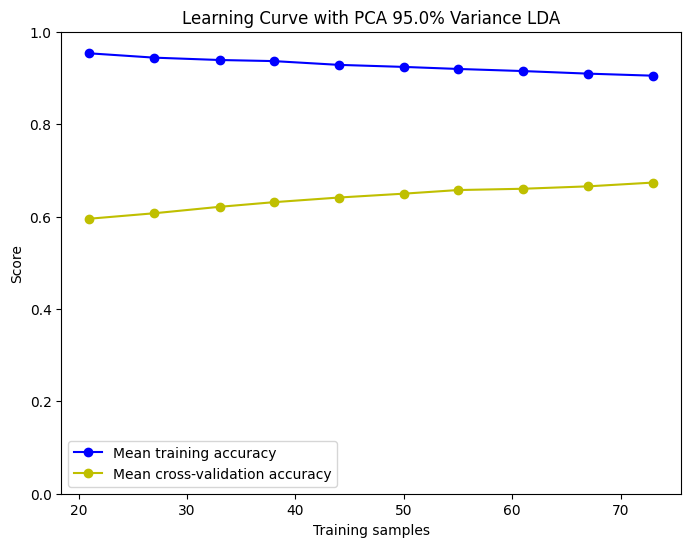

In [ ]:
train_sizes_all = np.linspace(.3, 1.0, 10)

# Loop for different percentages of variation described by PCA
components_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

for components in components_range:  # Variëren van het aantal PCA-componenten
    print(f"Testing with PCA variance ratio: {components}")

    # Initiate learning curve data
    all_train_scores = []
    all_test_scores = []
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))

    # 100 Random Splits
    for run in range(100):
        print(f"Run {run + 1}/100")

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2, random_state=run)

        # Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # PCA
        pca = PCA(n_components=components, random_state=run)  # Aantal componenten op basis van de variantie

        #LDA
        lda = LinearDiscriminantAnalysis()

        # Pipeline
        pipeline = make_pipeline(pca, lda)

        clf = pipeline
        clf.fit(X_train_scaled, y_train)


        # Learning curve
        train_sizes, train_scores, test_scores = learning_curve(clf, X_train_scaled, y_train,
                                                                train_sizes=train_sizes_all, cv=5, n_jobs=-1)
        all_train_scores.append(np.mean(train_scores, axis=1))
        all_test_scores.append(np.mean(test_scores, axis=1))

    # Mean Learning Curve
    mean_train_scores = np.mean(all_train_scores, axis=0)
    mean_test_scores = np.mean(all_test_scores, axis=0)
    axes.plot(train_sizes, mean_train_scores, 'o-', color="b", label="Mean training accuracy")
    axes.plot(train_sizes, mean_test_scores, 'o-', color="y", label="Mean cross-validation accuracy")
    axes.set_xlabel("Training samples")
    axes.set_ylabel("Score")
    axes.set_title(f"Learning Curve with PCA {components*100}% Variance LDA")
    axes.legend(loc="best")
    axes.set_ylim([0, 1])
    plt.show()


## LDA pipeline including testing on testset

Run 1/100
Accuracy     : 0.4348
Sensitiviteit: 0.6250
Specificiteit: 0.3333
F1-score     : 0.4348
AUC          : 0.5667
Run 2/100
Accuracy     : 0.3913
Sensitiviteit: 0.6250
Specificiteit: 0.2667
F1-score     : 0.4167
AUC          : 0.4750
Run 3/100
Accuracy     : 0.6957
Sensitiviteit: 0.6667
Specificiteit: 0.7273
F1-score     : 0.6957
AUC          : 0.7652
Run 4/100
Accuracy     : 0.5652
Sensitiviteit: 0.4167
Specificiteit: 0.7273
F1-score     : 0.5000
AUC          : 0.7121
Run 5/100
Accuracy     : 0.6522
Sensitiviteit: 0.7778
Specificiteit: 0.5714
F1-score     : 0.6364
AUC          : 0.7857
Run 6/100
Accuracy     : 0.6957
Sensitiviteit: 0.7143
Specificiteit: 0.6667
F1-score     : 0.7407
AUC          : 0.8016
Run 7/100
Accuracy     : 0.6957
Sensitiviteit: 0.6000
Specificiteit: 0.7692
F1-score     : 0.6316
AUC          : 0.7000
Run 8/100
Accuracy     : 0.5652
Sensitiviteit: 0.5000
Specificiteit: 0.6154
F1-score     : 0.5000
AUC          : 0.5846
Run 9/100
Accuracy     : 0.6957
Sensitiv

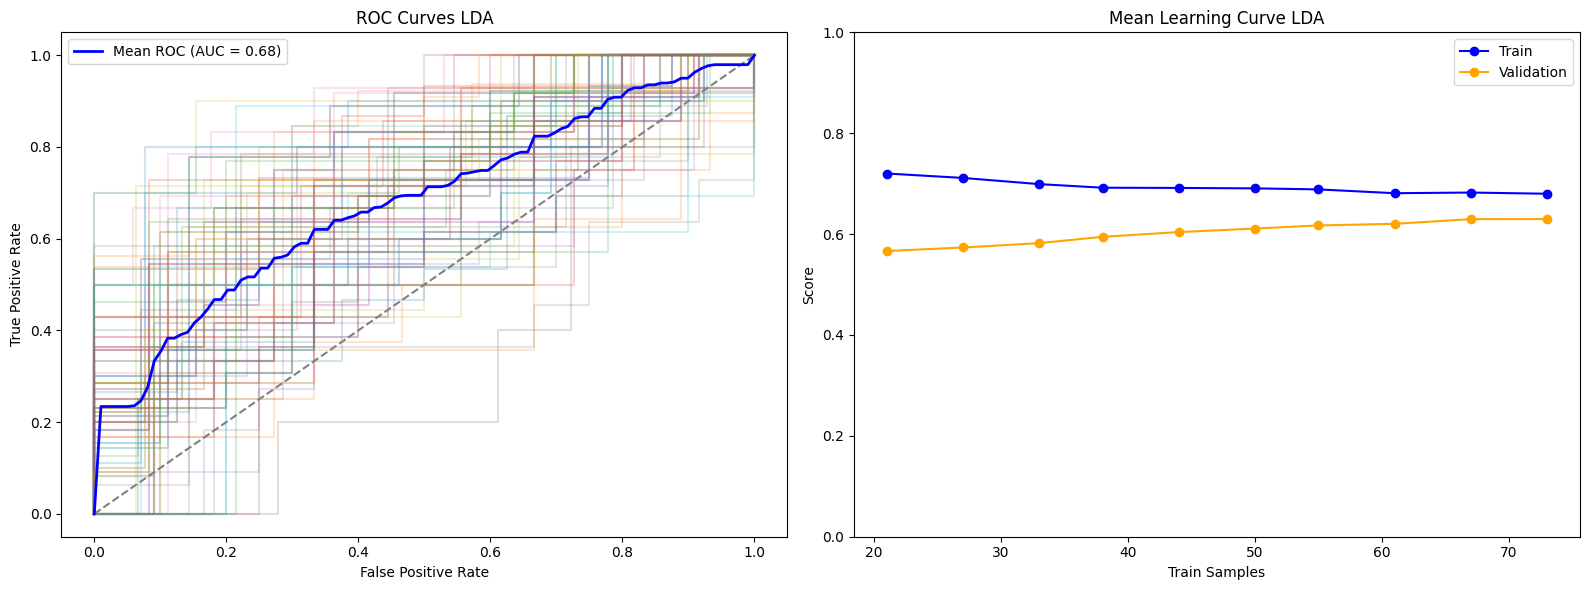

In [ ]:
# Initiate results
results = []
accuracies = []
sensitivities = []
specificities = []
f1_scores = []
auc_scores = []
roc_curves = []
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)


all_train_scores = []
all_test_scores = []
train_sizes_all = np.linspace(.3, 1.0, 10)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# 100 Random Splits
for run in range(100):
    print(f"Run {run + 1}/100")

    # Data split
    X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2, random_state=run)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # PCA + LDA
    pca = PCA(n_components = 0.5, random_state = run)
    lda = LinearDiscriminantAnalysis()

    # Pipeline
    pipeline = make_pipeline(pca, lda)
    clf = pipeline
    clf.fit(X_train_scaled, y_train)

    # Test model
    y_pred = clf.predict(X_test_scaled)
    y_score = clf.predict_proba(X_test_scaled)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_score = auc(fpr, tpr)

    print(f"Accuracy     : {accuracy:.4f}")
    print(f"Sensitiviteit: {sensitivity:.4f}")
    print(f"Specificiteit: {specificity:.4f}")
    print(f"F1-score     : {f1:.4f}")
    print(f"AUC          : {auc_score:.4f}")

    # Results
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    f1_scores.append(f1)
    auc_scores.append(auc_score)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    roc_curves.append((fpr, tpr, auc_score))

    results.append({
        "accuracy": accuracy,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "f1_score": f1,
        "auc": auc_score
    })

    # ROC curve
    axes[0].plot(fpr, tpr, alpha=0.2)

    # Learning curve
    train_sizes, train_scores, test_scores = learning_curve(clf, X_train_scaled, y_train,
                                                            train_sizes=train_sizes_all, cv=5, n_jobs=-1)
    all_train_scores.append(np.mean(train_scores, axis=1))
    all_test_scores.append(np.mean(test_scores, axis=1))

# Mean results
mean_accuracy = np.mean(accuracies)
mean_sensitivity = np.mean(sensitivities)
mean_specificity = np.mean(specificities)
mean_f1 = np.mean(f1_scores)
mean_auc = np.mean(auc_scores)

# Standard deviation results
std_accuracy = np.std(accuracies)
std_sensitivity = np.std(sensitivities)
std_specificity = np.std(specificities)
std_f1 = np.std(f1_scores)
std_auc = np.std(auc_scores)

# Confidence Intervals
ci_acc = stats.t.interval(0.95, len(accuracies)-1, loc=mean_accuracy, scale=std_accuracy/np.sqrt(len(accuracies)))
ci_sens = stats.t.interval(0.95, len(sensitivities)-1, loc=mean_sensitivity, scale=std_sensitivity/np.sqrt(len(sensitivities)))
ci_spec = stats.t.interval(0.95, len(specificities)-1, loc=mean_specificity, scale=std_specificity/np.sqrt(len(specificities)))
ci_f1 = stats.t.interval(0.95, len(f1_scores)-1, loc=mean_f1, scale=std_f1/np.sqrt(len(f1_scores)))
ci_auc = stats.t.interval(0.95, len(auc_scores)-1, loc=mean_auc, scale=std_auc/np.sqrt(len(auc_scores)))

# Print Summary
print("\n==== Summary ====")
print(f"Accuracy     : {mean_accuracy:.4f} ± {std_accuracy:.4f} (95% CI: {ci_acc})")
print(f"Sensitiviteit: {mean_sensitivity:.4f} ± {std_sensitivity:.4f} (95% CI: {ci_sens})")
print(f"Specificiteit: {mean_specificity:.4f} ± {std_specificity:.4f} (95% CI: {ci_spec})")
print(f"F1-score     : {mean_f1:.4f} ± {std_f1:.4f} (95% CI: {ci_f1})")
print(f"AUC          : {mean_auc:.4f} ± {std_auc:.4f} (95% CI: {ci_auc})")

# Top 10 results
top_results = sorted(results, key=lambda x: x["accuracy"], reverse=True)[:10]
print("\nTop 10 Beste Runs:")
for i, res in enumerate(top_results):
    print(f"{i+1}. Acc: {res['accuracy']:.4f}, Sens: {res['sensitivity']:.4f}, Spec: {res['specificity']:.4f}, F1: {res['f1_score']:.4f}, AUC: {res['auc']:.4f}")

# Plot ROC-curve
mean_tpr /= 100
mean_tpr[0]=0
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'Mean ROC (AUC = {mean_auc:.2f})')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curves LDA")
axes[0].legend(loc="best")

# Plot Learning Curve
mean_train_scores = np.mean(all_train_scores, axis=0)
mean_test_scores = np.mean(all_test_scores, axis=0)
axes[1].plot(train_sizes, mean_train_scores, 'o-', color="b", label="Train")
axes[1].plot(train_sizes, mean_test_scores, 'o-', color="orange", label="Validation")
axes[1].set_xlabel("Train Samples")
axes[1].set_ylabel("Score")
axes[1].set_title("Mean Learning Curve LDA")
axes[1].set_ylim(0, 1)
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()


# Comparison between best 4 performing models on same training and test data


Evaluatie van: Pipeline 1: PCA + KNN
Fold 1:
  Accuracy     : 0.6087
  Sensitiviteit: 0.5833
  Specificiteit: 0.6364
  F1-score     : 0.6087
  AUC          : 0.6515
Fold 2:
  Accuracy     : 0.5652
  Sensitiviteit: 0.2500
  Specificiteit: 0.9091
  F1-score     : 0.3750
  AUC          : 0.5909
Fold 3:
  Accuracy     : 0.6087
  Sensitiviteit: 0.4167
  Specificiteit: 0.8182
  F1-score     : 0.5263
  AUC          : 0.8106
Fold 4:
  Accuracy     : 0.6957
  Sensitiviteit: 0.6364
  Specificiteit: 0.7500
  F1-score     : 0.6667
  AUC          : 0.7576
Fold 5:
  Accuracy     : 0.6522
  Sensitiviteit: 0.5455
  Specificiteit: 0.7500
  F1-score     : 0.6000
  AUC          : 0.7159

==== Summary ====
Accuracy     : 0.6261 ± 0.0443 (95% CI: (np.float64(0.5710324438594204), np.float64(0.6811414691840577)))
Sensitiviteit: 0.4864 ± 0.1387 (95% CI: (np.float64(0.3142058650738195), np.float64(0.6585214076534531)))
Specificiteit: 0.7727 ± 0.0898 (95% CI: (np.float64(0.6612686398745754), np.float64(0.88418

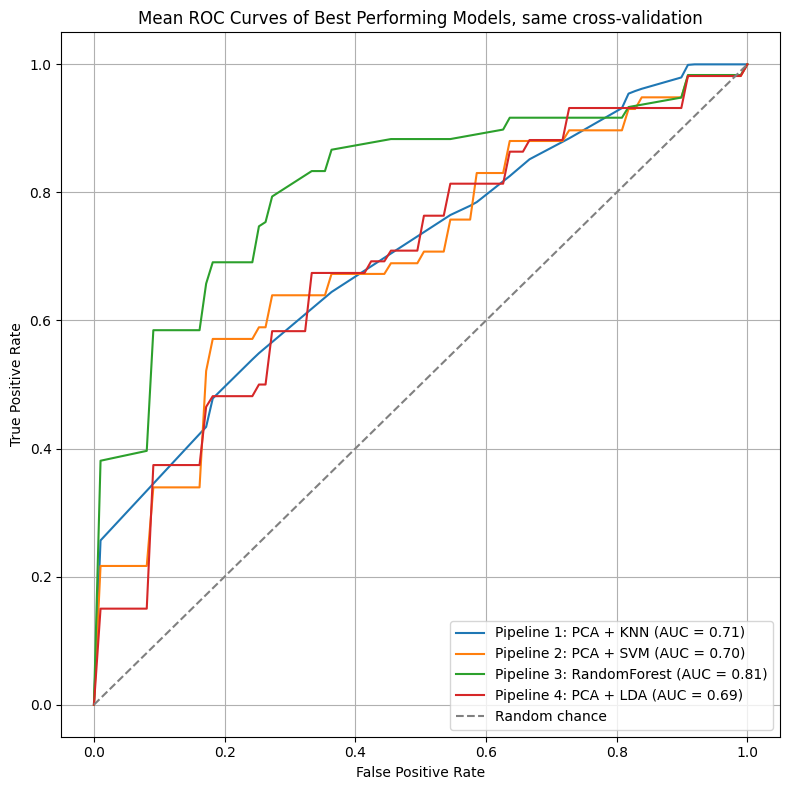


=== Overall Summary ===
                          mean_accuracy  mean_auc
Pipeline 3: RandomForest         0.7478    0.8114
Pipeline 1: PCA + KNN            0.6261    0.7053
Pipeline 2: PCA + SVM            0.6174    0.6985
Pipeline 4: PCA + LDA            0.6174    0.6909


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Pipelines
pipelines = {
    "Pipeline 1: PCA + KNN": make_pipeline(
        StandardScaler(),
        PCA(n_components=0.95),
        KNeighborsClassifier(n_neighbors=20, weights='uniform')
    ),
    "Pipeline 2: PCA + SVM": make_pipeline(
        StandardScaler(),
        PCA(n_components=0.6),
        SVC(C=0.1, kernel='linear', probability=True)
    ),
    "Pipeline 3: RandomForest": RandomForestClassifier(
        max_features=0.5,
        min_impurity_decrease=0.005,
        n_estimators=90,
        random_state=24
    ),
    "Pipeline 4: PCA + LDA": make_pipeline(
        StandardScaler(),
        PCA(n_components=0.5),
        LinearDiscriminantAnalysis()
    )
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
mean_fpr = np.linspace(0, 1, 100)

# Store overall results
results = {}

# Plot setup
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
axes.set_title("Mean ROC Curves of Best Performing Models, same cross-validation")

for name, pipeline in pipelines.items():
    print(f"\nEvaluatie van: {name}")
    accuracies = []
    sensitivities = []
    specificities = []
    f1_scores = []
    auc_scores = []
    mean_tpr = np.zeros_like(mean_fpr)
    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(cv.split(features, ground_truth), 1):
        X_train, X_test = features[train_idx], features[test_idx]
        y_train, y_test = ground_truth[train_idx], ground_truth[test_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_score = pipeline.predict_proba(X_test)[:, 1]
        accuracy = accuracy_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        auc_score = auc(fpr, tpr)

        print(f"Fold {fold}:")
        print(f"  Accuracy     : {accuracy:.4f}")
        print(f"  Sensitiviteit: {sensitivity:.4f}")
        print(f"  Specificiteit: {specificity:.4f}")
        print(f"  F1-score     : {f1:.4f}")
        print(f"  AUC          : {auc_score:.4f}")

        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        f1_scores.append(f1)
        auc_scores.append(auc_score)
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        fold_results.append({
            "accuracy": accuracy,
            "sensitivity": sensitivity,
            "specificity": specificity,
            "f1_score": f1,
            "auc": auc_score
        })

    mean_accuracy = np.mean(accuracies)
    mean_sensitivity = np.mean(sensitivities)
    mean_specificity = np.mean(specificities)
    mean_f1 = np.mean(f1_scores)
    mean_auc = np.mean(auc_scores)

    std_accuracy = np.std(accuracies)
    std_sensitivity = np.std(sensitivities)
    std_specificity = np.std(specificities)
    std_f1 = np.std(f1_scores)
    std_auc = np.std(auc_scores)

    ci_acc = stats.t.interval(0.95, len(accuracies)-1, loc=mean_accuracy, scale=std_accuracy/np.sqrt(len(accuracies)))
    ci_sens = stats.t.interval(0.95, len(sensitivities)-1, loc=mean_sensitivity, scale=std_sensitivity/np.sqrt(len(sensitivities)))
    ci_spec = stats.t.interval(0.95, len(specificities)-1, loc=mean_specificity, scale=std_specificity/np.sqrt(len(specificities)))
    ci_f1 = stats.t.interval(0.95, len(f1_scores)-1, loc=mean_f1, scale=std_f1/np.sqrt(len(f1_scores)))
    ci_auc = stats.t.interval(0.95, len(auc_scores)-1, loc=mean_auc, scale=std_auc/np.sqrt(len(auc_scores)))

    # Print Summary
    print("\n==== Summary ====")
    print(f"Accuracy     : {mean_accuracy:.4f} ± {std_accuracy:.4f} (95% CI: {ci_acc})")
    print(f"Sensitiviteit: {mean_sensitivity:.4f} ± {std_sensitivity:.4f} (95% CI: {ci_sens})")
    print(f"Specificiteit: {mean_specificity:.4f} ± {std_specificity:.4f} (95% CI: {ci_spec})")
    print(f"F1-score     : {mean_f1:.4f} ± {std_f1:.4f} (95% CI: {ci_f1})")
    print(f"AUC          : {mean_auc:.4f} ± {std_auc:.4f} (95% CI: {ci_auc})")

    # Save results for final summary
    results[name] = {
        "mean_accuracy": mean_accuracy,
        "mean_auc": mean_auc
    }

    # Plot ROC
    mean_tpr /= cv.get_n_splits()
    mean_tpr[0]=0
    axes.plot(mean_fpr, mean_tpr, label=f"{name} (AUC = {mean_auc:.2f})")

# Final ROC plot
axes.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random chance")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend(loc='lower right')
axes.grid(True)
plt.tight_layout()
plt.show()

# Summary
print("\n=== Overall Summary ===")
summary_df = pd.DataFrame.from_dict(results, orient='index')
print(summary_df.sort_values(by="mean_auc", ascending=False))
